# Solving the 1D Diffusion Equation with a Neural Network

In [188]:
import torch
from torch import nn
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import os

In [189]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *
from diffusion_common import *
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [191]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=False
save_dir = "../../../tex/02_neural_nets_on_pdes/img/"

# Some shorthands for figure labels/legends
MSE = r"$\mathrm{MSE}_\mathcal{V}$"

In [192]:
torch.set_default_dtype(torch.float32)

### 1D Diffusion Equation

In [193]:
# Functions below specify the initial boundary value problem (in terms of its residuals/deviations) alongside its analytic solution
def u0(u, x, t):
    return u - np.sin(np.pi * x), torch.zeros_like(u)

def dirichlet_bc(u, x, t):
    return u, torch.zeros_like(u)

def diffusion_equation(u, x, t):
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    return u_xx - u_t, torch.zeros_like(u)
diffusion_equation.domain_dim=2
diffusion_equation.target_dim=1

def spatio_temportal_sample_latin_hypercube(T, N_st, N_s, N_t):
    sampler1d = lambda N: torch.from_numpy(LatinHypercube(1).random(n = N)).float()
    # Excludes boundaries naturally
    sampler2d = lambda N: torch.from_numpy(LatinHypercube(2).random(n = N)).float()
    
    #Interior points
    samples_xt = sampler2d(N_st)
    samples_xt[:,1] *= T
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = sampler1d(N_t)
    samples_t_ic = torch.zeros((N_t,1))
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_t_bc = torch.repeat_interleave(T * sampler1d(N_s), 2, dim=0)
    samples_x_bc = torch.empty((2 * N_s,1))
    samples_x_bc[0::2,0] = 0.
    samples_x_bc[1::2,0] = 1.
    
    return samples_xt, \
           torch.cat((samples_x_ic, samples_t_ic),1), \
           torch.cat((samples_x_bc, samples_t_bc), 1)
    
def spatio_temportal_sample_cfl(T, N_s, cfl=ftcs_cfl_condition):
    dx = 1.0/(N_s - 1)
    dt = cfl(dx)
    
    N_t = int(2/dx**2 + 1)
    x = torch.from_numpy(dx * np.arange(N_s)).reshape(-1,1).float()
    t = torch.from_numpy(dt * np.arange(N_t)).reshape(-1,1).float()
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = x
    samples_t_ic = torch.zeros_like(samples_x_ic)
    
    # Interior points
    samples_xt = torch.from_numpy(np.dstack(np.meshgrid(x[1:-1], t[1:])).reshape(-1, 2)).float()
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_x_bc = torch.empty((2 * N_t,1))
    samples_x_bc[0::2,0] = 0.
    samples_x_bc[1::2,0] = 1.
    samples_t_bc = torch.repeat_interleave(t, 2, dim=0)
    
    return samples_xt, \
           torch.cat((samples_x_ic, samples_t_ic),1), \
           torch.cat((samples_x_bc, samples_t_bc), 1)

### Generate Test/Train Split

In [194]:
def unpack_sample(xt):
    return xt[:,0].reshape(-1,1), xt[:,-1].reshape(-1,1)

#IBVP parameters
T = 1
N_interior =  2**10
N_bc = 2**9
N_ic = 2**8
X_train = spatio_temportal_sample_latin_hypercube(T, N_interior, N_bc, N_ic)

#N_ic_test = 11 
#X_test = spatio_temportal_sample_cfl(T, N_ic_test)

X_test = spatio_temportal_sample_latin_hypercube(T, N_interior, N_bc, N_ic)

torch.Size([1024, 2]) torch.Size([256, 2]) torch.Size([1024, 2])


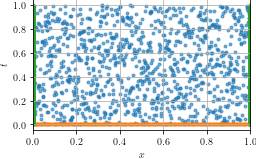

In [195]:
xt_int, xt_ic, xt_bc = X_test
save=True
size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
print(xt_int.shape, xt_ic.shape, xt_bc.shape)
ax.scatter(*unpack_sample(xt_int), alpha=0.6, edgecolor=None, marker=".")
ax.scatter(*unpack_sample(xt_ic), alpha=0.6, edgecolor=None, marker=".")
ax.scatter(*unpack_sample(xt_bc), alpha=0.6, edgecolor=None, marker=".")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$t$")

if save:
    fig.savefig(save_dir + "diffusion_pinn_validation_set.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

### Training of the Network

In [14]:
def early_convergence(loss):
    if np.abs(1.0 - loss / early_convergence.last_loss) < 1e-10:
        return True
    else:
        early_convergence.last_loss = loss
        return False
early_convergence.last_loss = np.inf
early_convergence.terminate = True

diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, events_for_loss=[early_convergence], verbose=True)
#print(diffusion_nn)
diffusion_nn.fit(X_train)

-----------------------------Training Log-----------------------------
# of collocation points:                                          1024
# of boundary points:                                             1024
# of initial condition:                                            128
Points per Iteration:                                           2176.0
----------------------------------------------------------------------
  Epoch   |  Total Loss   |  Loss (PDE)   |   Loss (BC)   |   Loss (IC)   
    0     |  1.50339e-01  |  9.94180e-03  |  5.18481e-02  |  8.85488e-02  
    20    |  7.55664e-05  |  6.64537e-05  |  6.12108e-06  |  2.99160e-06  
    40    |  5.57994e-06  |  4.90552e-06  |  5.59031e-07  |  1.15392e-07  
early_convergence fired terminal event after 44 epochs


## Hyperparameter Tuning

### Randomized Parameter Sweep

In [27]:
from ray.tune.schedulers import ASHAScheduler

def no_increasing_loss(trial_id, result):
    if result["training_iteration"] == 1:
        no_increasing_loss.max_loss = result["validation_loss"]
        return False
    return result["validation_loss"] > no_increasing_loss.max_loss

parameter_space = {
    "layers": tune.randint(1, 4),
    "nodes": tune.randint(5,40),
    "lr": tune.loguniform(1e-4, 1e-1),
    "optimizer_name": tune.choice(["lbfgs","adam"]),
    "number_of_minibatches": 1,
    "activation_function": nn.Tanh()
}
reasonable_start = [
    {
        "layers": 3,
        "nodes": 20,
        "lr": 1e-3,
        "optimizer_name": "lbfgs"
    }
]

fixed_parameters = {
    "epochs": 1000
}


diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, hyperparameters=fixed_parameters, verbose=False)
scheduler=ASHAScheduler(max_t=fixed_parameters["epochs"], grace_period=5, brackets=3)

analysis = tune.run(tune.with_parameters(diffusion_nn.train, X_train=X_train, X_test=X_test),
                    config=parameter_space,
                    num_samples=200,
                    max_failures=2,
                    metric="validation_loss",
                    mode="min",
                    scheduler=scheduler,
                    stop=no_increasing_loss,
                    local_dir="../data/ray",
                    name="diffusion_pinn",
                    resume="AUTO",
                    verbose=1)

2022-04-27 15:29:43,461	INFO tune.py:701 -- Total run time: 109.31 seconds (109.14 seconds for the tuning loop).


{'layers': 3, 'nodes': 39, 'lr': 0.05300787532779822, 'optimizer_name': 'lbfgs', 'number_of_minibatches': 1, 'activation_function': Tanh()}


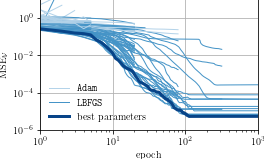

In [29]:
save=True
size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
ax.set_xscale("log")
ax.set_yscale("log")

dfs = analysis.trial_dataframes
best_df = analysis.best_dataframe
best_cfg = analysis.best_config

blues = sns.color_palette("Blues",12)

for k,d in dfs.items():
    if "adam" in k:
        line_adam, = ax.plot(d.training_iteration, d.validation_loss, color=blues[3], lw=1)
    else:
        line_lbfgs, = ax.plot(d.training_iteration, d.validation_loss, color=blues[7], lw=1)
        
ax.plot(best_df.training_iteration, best_df.validation_loss, color=blues[11], lw=3, label=r"best parameters")
line_adam.set_label(rf"\texttt{{Adam}}")
line_lbfgs.set_label(rf"\texttt{{LBFGS}}")
ax.set_ylim([1e-6,1e1])
ax.set_xlabel(r"epoch")
ax.set_ylabel(MSE)
handles, labels = ax.get_legend_handles_labels()
labels = np.array(labels)
handles = np.array(handles)
permutation = np.argsort(labels)
labels = labels[permutation]
handles = handles[permutation]
ax.legend(handles, labels)

if save:
    fig.savefig(save_dir + "diffusion_pinn_hyperopt.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

In [30]:
logdir = analysis.best_logdir
best_cfg["hidden_layers"] = best_cfg["layers"] * [best_cfg["nodes"]]
best_cfg["optimizer_params"] = {"lr":best_cfg["lr"]}
best_cfg = best_cfg | fixed_parameters
state_dict = torch.load(os.path.join(logdir, "model.pth"))
print(best_cfg)

{'layers': 3, 'nodes': 39, 'lr': 0.05300787532779822, 'optimizer_name': 'lbfgs', 'number_of_minibatches': 1, 'activation_function': Tanh(), 'hidden_layers': [39, 39, 39], 'optimizer_params': {'lr': 0.05300787532779822}, 'epochs': 1000}


### Comparison between PiNN, FTCS and Analytical Solution

In [154]:
#Load the best PiNN found through hyperparameter tuning
best_diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, hyperparameters=best_cfg, verbose=False)
best_diffusion_nn.net.load_state_dict(state_dict)

<All keys matched successfully>

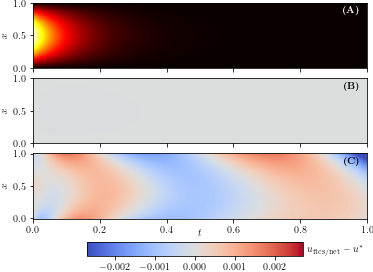

In [155]:
#Evaluate the residual between PINN/FTCS and the analytical solution on a common grid.
#Since PiNN's are discretization agnositic we can simply insert the FTCS-grid.
dx = 1e-2
u_ftcs = np.load(f"../data/diffusion/diffusion_solution_ftcs_dx_{dx:.2e}.npy")
x = np.load(f"../data/diffusion/diffusion_x_dx_{dx:.2e}.npy")
t = np.load(f"../data/diffusion/diffusion_t_dx_{dx:.2e}.npy")

N_t = t.shape[-1]
N_x = x.shape[-1]
xx, tt = np.meshgrid(x,t)
u_ana = u_analytical(xx,tt)
xt = dstack_product(x,t)

X_test = torch.from_numpy(xt).float()
u_net = best_diffusion_nn.predict(X_test).reshape(N_t, N_x)

save=True
size = (3.9, 3.5 * 0.618 * 3.9) if save else (10,6)
fig, ax = plt.subplots(nrows=3, sharex=True)
labels = [r"\textbf{(A)}",r"\textbf{(B)}",r"\textbf{(C)}"]
label_colors = ["w", "k", "k"]
for a,label,c in zip(ax,labels,label_colors):
    a.grid(False)
    a.set_ylabel(r"$x$")
    a.text(0.98, 0.95, label, transform=a.transAxes, ha="right", va="top", color=c)
    
for tk in ax[0].get_xticklabels():
    tk.set_visible(True)
for tk in ax[-1].get_xticklabels():
    tk.set_visible(True)
    
halfrange=1.5 * torch.max(u_net-u_ana)
ax[0].pcolormesh(tt,xx,u_ana,rasterized=True,cmap="hot")
im = ax[1].pcolormesh(tt, xx, u_ftcs-u_ana,
                      cmap="coolwarm",
                      rasterized=True,
                      norm=colors.CenteredNorm(halfrange=halfrange))
im = ax[2].pcolormesh(tt, xx, u_net-u_ana,
                      cmap="coolwarm",
                      rasterized=True,
                      norm=colors.CenteredNorm(halfrange=halfrange))

plt.subplots_adjust(bottom=.13, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.25, 0, 0.5, 0.05])
cbar_ax.grid(False)
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")


cbar_ax.set_xlabel(r"$u_\mathrm{ftcs/net} - u^{*}$")
cbar_ax.xaxis.set_label_coords(1.15, 0.75)

ax[-1].set_xlabel(r"$t$")
ax[-1].xaxis.set_label_coords(.5, -0.15)
if save:
    fig.savefig(save_dir + f"diffusion_ftcs_pinn_residual_dx_{dx:.2e}.pdf",bbox_inches="tight",
                dpi=600,
                pad_inches = 0.02)
else:
    plt.show()

### Computing $L_2$ Errors

In [176]:
from tabulate import tabulate
from scipy.integrate import simps

dxs = np.array([1e-1, 5e-2, 2e-2, 1e-2, 5e-3])
table = []
l2_net = []
l2_ftcs = []
for dx in dxs:
    x = np.load(f"../data/diffusion/diffusion_x_dx_{dx:.2e}.npy")
    t = np.load(f"../data/diffusion/diffusion_t_dx_{dx:.2e}.npy")
    u_ftcs = np.load(f"../data/diffusion/diffusion_solution_ftcs_dx_{dx:.2e}.npy")
    
    xx, tt = np.meshgrid(x,t)
    u_ana = u_analytical(xx,tt)

    l2_ftcs.append(np.sqrt(simps(simps(np.abs(u_ftcs - u_ana)**2, x=t, axis=0), x=x)))

    xt = dstack_product(x,t)
    X_test = torch.from_numpy(xt).float()
    u_net = best_diffusion_nn.predict(X_test).reshape(t.shape[-1], x.shape[-1])
    l2_net.append(np.sqrt(simps(simps(np.abs(u_net - u_ana)**2, x=t, axis=0), x=x)))
    dxdt = dx * ftcs_cfl_condition(dx)
    table.append([f"{dxdt:.2e}", f"{l2_ftcs[-1]:.6e}", f"{l2_net[-1]:.6e}"])

print(tabulate(table, headers = [r"\Delta x\Delta t",r"||u_\mathrm{ftcs} - u^{*}||_2",r"||u_\mathrm{net} - u^{*}||_2"], 
               tablefmt="pretty"))

+------------------+-------------------------------+------------------------------+
| \Delta x\Delta t | ||u_\mathrm{ftcs} - u^{*}||_2 | ||u_\mathrm{net} - u^{*}||_2 |
+------------------+-------------------------------+------------------------------+
|     5.00e-04     |         1.317584e-03          |         7.310300e-04         |
|     6.25e-05     |         3.239110e-04          |         7.309439e-04         |
|     4.00e-06     |         7.408948e-05          |         7.309394e-04         |
|     5.00e-07     |         1.851460e-05          |         7.309396e-04         |
|     6.25e-08     |         4.628164e-06          |         7.309400e-04         |
+------------------+-------------------------------+------------------------------+


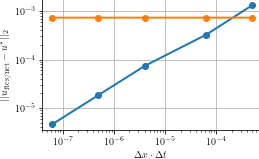

In [183]:
save=True
size = (3.9, 0.618 * 3.9) if save else (10,6)
fig, ax = plt.subplots(figsize=size)
ax.set_xscale("log")
ax.set_yscale("log")


ax.plot(dxs * ftcs_cfl_condition(dxs), l2_ftcs, color="C0")
ax.scatter(dxs * ftcs_cfl_condition(dxs), l2_ftcs, color="C0")
plt.plot(dxs * ftcs_cfl_condition(dxs), l2_net, color="C1")
ax.scatter(dxs * ftcs_cfl_condition(dxs), l2_net, color="C1")
ax.set_xlabel(r"$\Delta x \cdot \Delta t$")
ax.set_ylabel(r"$||u_\mathrm{ftcs/net} - u^{*}||_2$")
ax.set_xlim([4e-8,7e-4])
plt.show()

if save:
    fig.savefig(save_dir + "diffusion_ftcs_pinn_l2_error.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()